In [454]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TensorBoard

In [455]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import regularizers
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
import pandas as pd
import time

### Paths

In [456]:
celeba_path = Path('../../../Dataset/img_celeba_cropped/')
celeba_identity_path = Path('../../../Dataset/identity_CelebA.txt')
celeba_attributes_path = Path('../../../Dataset/list_attr_celeba.txt')

### Hyperparameters

In [457]:
triplets_count=5000

train_size=0.7

network_input_shape=(224, 224, 3)

batch_size=32
lr=1e-4

### Creating triplets

In [458]:
df_identity = pd.read_csv(celeba_identity_path, sep = " ", names=["image", "identity"], dtype=str)

In [459]:
def create_n_triplets(df_identity, n):
    triplets = []
    
    for triplet in range(n):
        anchor_id = df_identity['identity'].sample(1, replace=True).to_string(index=False)
    
        anchor, positive = df_identity.loc[df_identity['identity'] == anchor_id]['image'].sample(2, replace=True)
        negative = df_identity.loc[df_identity['identity'] != anchor_id]['image'].sample(1, replace=True).to_string(index=False)
        
        anchor = str(celeba_path) + '/' + anchor
        positive = str(celeba_path) + '/' + positive
        negative = str(celeba_path) + '/' + negative
        
        triplets.append([anchor, positive, negative])
        
    
    return pd.DataFrame(triplets, columns=['anchor', 'positive', 'negative'])

In [460]:
triplets = create_n_triplets(df_identity, triplets_count)
triplets.head()

,anchor,positive,negative
0,../../../Dataset/img_celeba_cropped/168289.jpg,../../../Dataset/img_celeba_cropped/171609.jpg,../../../Dataset/img_celeba_cropped/190933.jpg
1,../../../Dataset/img_celeba_cropped/066443.jpg,../../../Dataset/img_celeba_cropped/156028.jpg,../../../Dataset/img_celeba_cropped/130732.jpg
2,../../../Dataset/img_celeba_cropped/084781.jpg,../../../Dataset/img_celeba_cropped/059497.jpg,../../../Dataset/img_celeba_cropped/163636.jpg
3,../../../Dataset/img_celeba_cropped/126240.jpg,../../../Dataset/img_celeba_cropped/019139.jpg,../../../Dataset/img_celeba_cropped/045197.jpg
4,../../../Dataset/img_celeba_cropped/001273.jpg,../../../Dataset/img_celeba_cropped/065304.jpg,../../../Dataset/img_celeba_cropped/002649.jpg


In [461]:
def visualize_triplets(triplets):
    def show(ax, path):
        img = cv2.imread(path)
        
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], triplets.iloc[i][0])
        show(axs[i, 1], triplets.iloc[i][1])
        show(axs[i, 2], triplets.iloc[i][2])

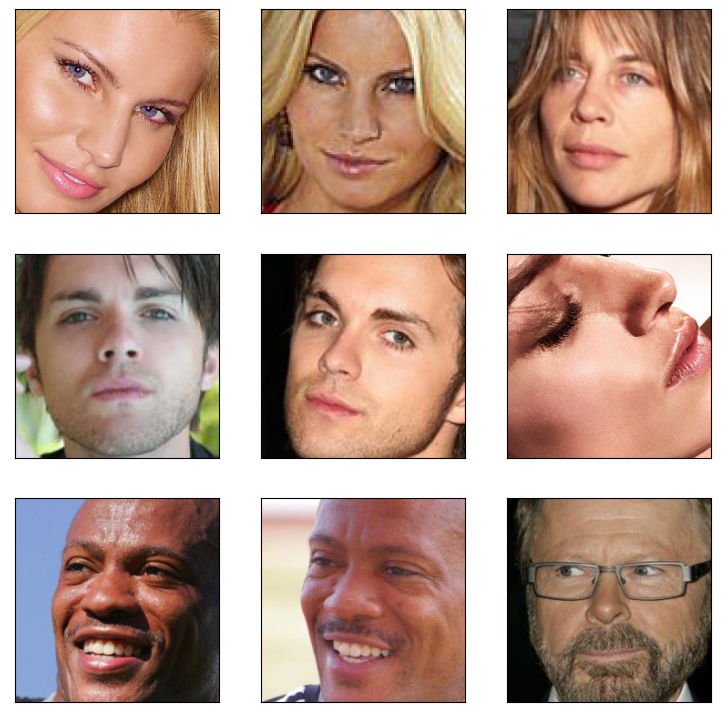

In [462]:
visualize_triplets(triplets)

### TF Pipeline

In [463]:
def preprocessing(anchor, positive, negative):
    return (
        convert_to_img(anchor), 
        convert_to_img(positive), 
        convert_to_img(negative)
    )


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = resnet50.preprocess_input(img)
    return img

In [464]:
features = tf.data.Dataset.from_tensor_slices((triplets['anchor'].values, triplets['positive'].values, triplets['negative'].values))
features = features.map(preprocessing)

fake_labels = tf.data.Dataset.from_tensor_slices(np.ones(triplets_count))


dataset = tf.data.Dataset.zip((features, fake_labels))

### Test val splits

In [465]:
train_dataset = dataset.take(round(triplets_count * train_size))
val_dataset = dataset.skip(round(triplets_count * train_size))

In [466]:
### Performance optimization

In [467]:
train_dataset = train_dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Models

### Resnet 50

In [468]:
def resnet_embedding():
    input = layers.Input(shape=network_input_shape)
    
    base_cnn=resnet50.ResNet50(
        input_tensor=input,
        include_top=False,
        input_shape=network_input_shape,
        weights='imagenet'
    )

    for layer in base_cnn.layers[0:-1]:
        layer.trainable = False
        
    model = layers.Flatten()(base_cnn.output)
    #model = layers.BatchNormalization()(model)
    model = tf.keras.layers.Dropout(0.2)(model)
    model = layers.Dense(2048, activation="leaky_relu")(model)

    return Model(input, outputs=model, name='resnet50')

### Convnet

In [469]:
def conv_embedding():
    input = layers.Input(shape=network_input_shape)
    x = layers.Flatten()(input)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    
    x = layers.Dense(248, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    
    x = layers.Dense(248, activation='relu')(x)
    x = layers.Dropout(.2)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    return Model(inputs=input, outputs=x, name='dense_net')

In [470]:
class TripletLoss(layers.Layer):

    def __init__(self, margin, **kwargs):
        self.margin = margin
        super().__init__(**kwargs)
        
    def euclidean_distance(self, x, y):
        sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
        return tf.sqrt(tf.maximum(sum_square, K.epsilon()))
    

    def call(self, anchor, positive, negative):
        positive_distance = self.euclidean_distance(anchor, positive)
        negative_distance = self.euclidean_distance(anchor, negative)
        
        loss = positive_distance - negative_distance
        
        return tf.maximum(loss + self.margin, 0.0)

In [471]:
def identity_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred)

In [472]:
anchor_input = layers.Input(shape=network_input_shape, name='anchor_input')
positive_input = layers.Input(shape=network_input_shape, name='right_input')
negative_input = layers.Input(shape=network_input_shape, name='negative_input')

In [473]:
#embedding = convnet_embedding()
embedding = resnet_embedding()

distances = TripletLoss(margin=1)(
    embedding(anchor_input), 
    embedding(positive_input), 
    embedding(negative_input)
)

model = Model(
    inputs=[anchor_input, positive_input, negative_input], 
    outputs=distances,
    name='resnet50',
)

In [474]:
def identity_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred)

In [475]:
model.compile(
    optimizer=Adam(learning_rate=lr), 
    loss=identity_loss,
)

In [476]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                         

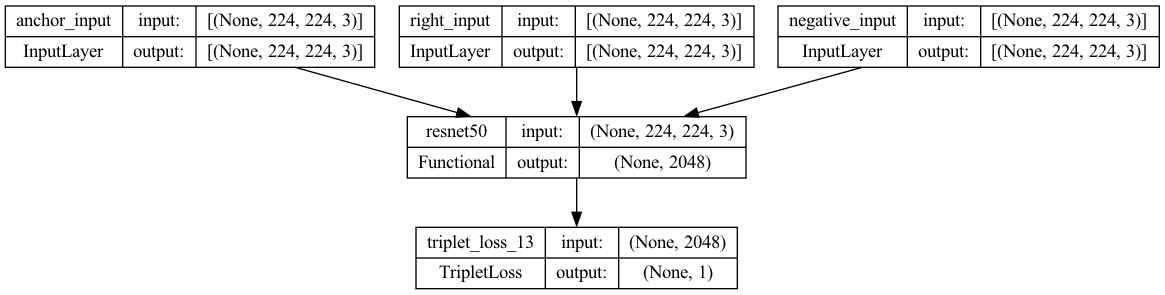

In [477]:
tf.keras.utils.plot_model(model, show_shapes=True)

### a) Loading model

In [478]:
#model = keras.models.load_model(model_path)

### b) Training and saving a new model

### Callbacks

In [479]:
tensorboard = TensorBoard(
    log_dir=f"logs/{model.name}_{time.strftime('run_%Y_%m_%d-%H_%M_%S')}",
    histogram_freq = 1, 
    embeddings_freq=1)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True 
)

lr_scheduler_reduce = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [480]:
callbacks_list = [
    early_stopping,
    lr_scheduler_reduce,
]

In [481]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    callbacks=callbacks_list,
    epochs=10, 
)

Epoch 1/10


2022-12-04 00:11:53.023128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - ETA: 0s - loss: 2.9371

2022-12-04 00:14:07.248098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 187s 2s/step - loss: 2.9371 - val_loss: 3.0861 - lr: 1.0000e-04
Epoch 2/10
110/110 [==============================] - 148s 1s/step - loss: 0.5912 - val_loss: 4.3635 - lr: 1.0000e-04
Epoch 3/10
110/110 [==============================] - 136s 1s/step - loss: 0.2123 - val_loss: 4.7367 - lr: 1.0000e-04
Epoch 4/10
110/110 [==============================] - 143s 1s/step - loss: 0.1205 - val_loss: 4.6216 - lr: 1.0000e-04
Epoch 5/10
110/110 [==============================] - 146s 1s/step - loss: 0.0733 - val_loss: 5.2891 - lr: 1.0000e-04
Epoch 6/10
110/110 [==============================] - 143s 1s/step - loss: 0.1207 - val_loss: 5.2832 - lr: 1.0000e-04
Epoch 7/10
110/110 [==============================] - 137s 1s/step - loss: 0.0563 - val_loss: 5.0619 - lr: 5.0000e-05
Epoch 8/10
110/110 [==============================] - 139s 1s/step - loss: 0.0233 - val_loss: 4.9960 - lr: 5.0000e-05
Epoch 9/10
110/110 [==============================] - 143s 1s/step 

### Save model

In [482]:
#checkpoints_path = 'checkpoints'
#model_version = f'{model.name}-{time.strftime("%Y%m%d-%H%M%S")}'

#model_path = f'checkpoints/{model_version}'
#model.save(model_path)

### Performance evaluation

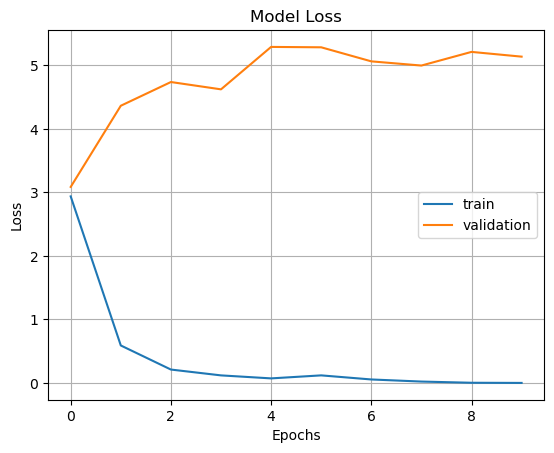

In [483]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

### Predictions

In [518]:
def create_balanced_pairs(df_identity, images):
    pairs = []
    
    for triplet in range(images):
        anchor_id = df_identity['identity'].sample(1, replace=True).to_string(index=False)
        
        positive_pair = df_identity.loc[df_identity['identity'] == anchor_id]['image'].sample(2, replace=True).to_list()
        negative = df_identity.loc[df_identity['identity'] != anchor_id]['image'].sample(1, replace=True).to_string(index=False)
        
        positive_pair[0] = str(celeba_path) + '/' + positive_pair[0]
        positive_pair[1] = str(celeba_path) + '/' + positive_pair[1]
        negative = str(celeba_path) + '/' + negative
        
        pairs.append([positive_pair[0], positive_pair[1], 1])
        pairs.append([positive_pair[0], negative, 0])
    
    return pd.DataFrame(pairs, columns=['left', 'right', 'label'])

In [519]:
pairs = create_balanced_pairs(df_identity, 500)

In [520]:
pairs.head(6)

,left,right,label
0,../../../Dataset/img_celeba_cropped/002898.jpg,../../../Dataset/img_celeba_cropped/067325.jpg,1
1,../../../Dataset/img_celeba_cropped/002898.jpg,../../../Dataset/img_celeba_cropped/006086.jpg,0
2,../../../Dataset/img_celeba_cropped/184674.jpg,../../../Dataset/img_celeba_cropped/192008.jpg,1
3,../../../Dataset/img_celeba_cropped/184674.jpg,../../../Dataset/img_celeba_cropped/092942.jpg,0
4,../../../Dataset/img_celeba_cropped/113735.jpg,../../../Dataset/img_celeba_cropped/061197.jpg,1
5,../../../Dataset/img_celeba_cropped/113735.jpg,../../../Dataset/img_celeba_cropped/100540.jpg,0


In [521]:
def visualize_pairs(pairs):
    def show(ax, path):
        img = cv2.imread(path)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(5, 15))

    axs = fig.subplots(6, 2)
    for i in range(6):
        show(axs[i, 0], pairs.iloc[i][0])
        show(axs[i, 1], pairs.iloc[i][1])

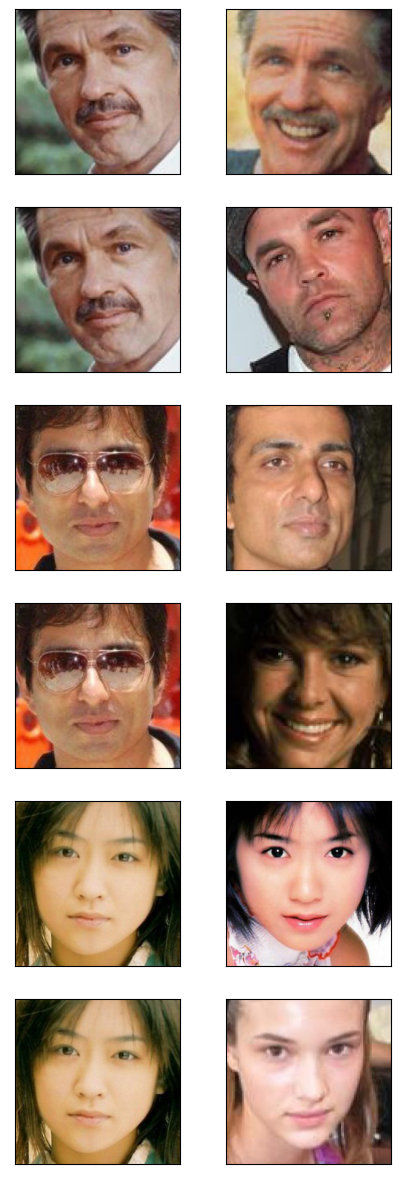

In [522]:
visualize_pairs(pairs)

In [523]:
def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [524]:
test_ds_left = create_singular_dataset(pairs['left'])
test_ds_right = create_singular_dataset(pairs['right'])
test_labels = pairs['label']

In [525]:
left_image_feature_vectors = embedding.predict(test_ds_left)
right_image_feature_vectors = embedding.predict(test_ds_right)

32/32 [==============================] - 7s 231ms/step


In [526]:
positive_left_image_feature_vectors = left_image_feature_vectors[0::2]
negative_left_image_feature_vectors = left_image_feature_vectors[1::2]

positive_right_image_feature_vectors = right_image_feature_vectors[0::2]
negative_right_image_feature_vectors = right_image_feature_vectors[1::2]

In [527]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [528]:
positive_distances = euclidean_distance((positive_left_image_feature_vectors, positive_right_image_feature_vectors)).numpy().flatten()
positive_mean = pd.Series(positive_distances).mean()
pd.Series(positive_distances).describe()

count    500.000000
mean     154.493530
std       45.844494
min        0.000316
25%      144.626572
50%      160.673691
75%      178.375038
max      251.122940
dtype: float64

In [529]:
negative_distances = euclidean_distance((negative_left_image_feature_vectors, negative_right_image_feature_vectors)).numpy().flatten()
negative_mean = pd.Series(negative_distances).mean()
pd.Series(negative_distances).describe()

count    500.000000
mean     191.338501
std       31.225685
min      118.924171
25%      169.625931
50%      187.163887
75%      211.971527
max      317.810547
dtype: float64

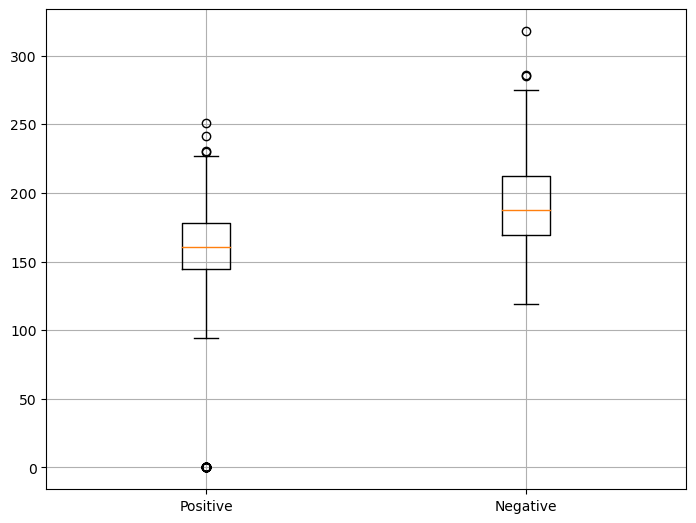

In [530]:
fig = plt.figure()
ax = fig.add_axes([0,0,1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [531]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred.flatten() < cutoff
    return np.mean(pred == y_true), pred

In [532]:
y_pred = np.linalg.norm(left_image_feature_vectors-right_image_feature_vectors, axis=1)
cutoff = (positive_mean + negative_mean)/2

In [533]:
test_accuracy, y_pred = compute_accuracy(test_labels, y_pred, cutoff)
print(f'Accuracy: {test_accuracy*100:.2f}%')

Accuracy: 69.20%


<AxesSubplot: >

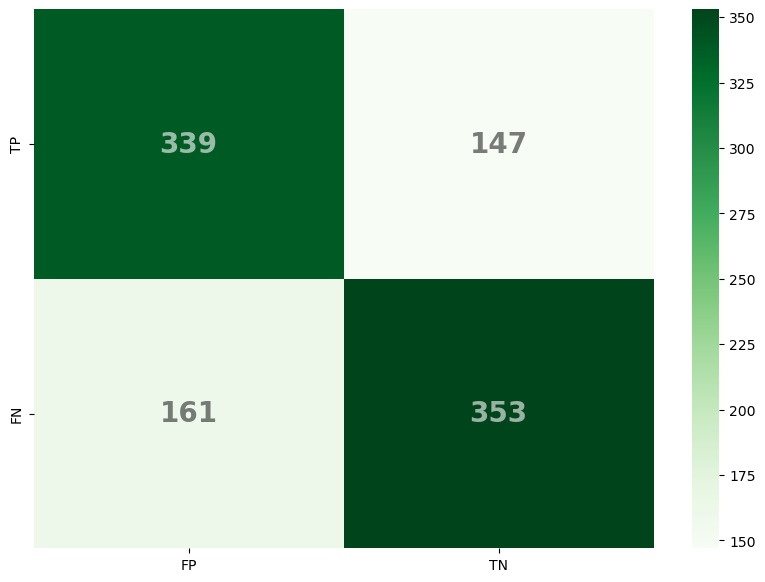

In [537]:
c_matrix = confusion_matrix(y_pred, test_labels, labels = [1,0])
c_matrix_df = pd.DataFrame(c_matrix, index=["TP", "FN"], columns=["FP", "TN"])
plt.figure(figsize=(10,7))
sn.heatmap(c_matrix_df, cmap="Greens", annot=True,
          annot_kws={'fontsize': 20, 'fontweight': 'bold', 'alpha': 0.6},
          fmt='g')

### Observe FP and FN